# Neural Artistic Style Transfer

This interactive notebook shows how to use the python package `style` for performing artistic style transfer between a source and a style image. 

See https://github.com/cheind/py-style-transfer for more details.

### Header

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import torch
import numpy as np
from IPython.display import display, clear_output

import matplotlib
import matplotlib.pyplot as plt

np.random.seed(456);
torch.manual_seed(456);

In [3]:
def show_progress(g, shape):

    fig, ax = plt.subplots()
    img = ax.imshow(np.zeros(shape, np.float32))
    ax.set_axis_off()

    for x in g:
        clear_output(wait=True)
        img.set_data(x)
        display(fig)
    clear_output(wait=True)

### Import libary

In [4]:
import style
bb = style.Backbone()
st = style.IteratedStyleTransfer(bb)

### Visualizing Style Transfer

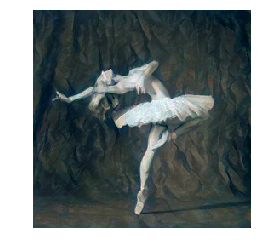

In [5]:
p = style.image.open('etc/dancing.jpg').scale_long_to(256)
a = style.image.open('etc/picasso.jpg').scale_long_to(256)

# Get a generator object which allows visualizing the drawing process.
g = st.generate(
    content=style.Content(p),
    style=style.GramStyle(a),    
    seed=p,
    yield_every=20,
    niter=100)

show_progress(g, p.shape)

To receive just the final result, drop the `yield_every` field and call `next` on the generator to receive the final result. This is shown below with some parameters changed.

100%|███████████████████████| 200/200 [00:04<00:00, 41.47it/s, loss=[3.512e-05 0.000e+00 3.385e-05 1.276e-06], lr=0.01]


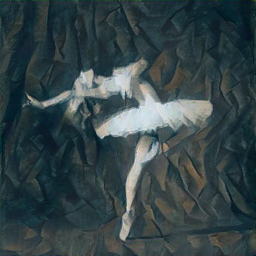

In [6]:
g = st.generate(
    content=style.Content(p, lambda_loss=0),
    style=style.GramStyle(a, [4,8,12,14]),
    seed=p)

next(g)

## Multiscale

Multiscaling performs style transfer on various image resolutions.

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  1.85s/it]


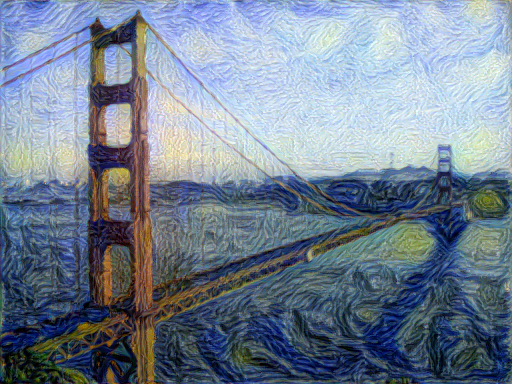

In [7]:
p = style.image.open('etc/bridge.jpg').scale_long_to(512)
a = style.image.open('etc/vangogh.jpg').scale_long_to(512)

g = st.generate_multiscale(
    content=style.Content(p), 
    style=style.GramStyle(a), 
    seed=p,
    niter=100)

next(g)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.36s/it]


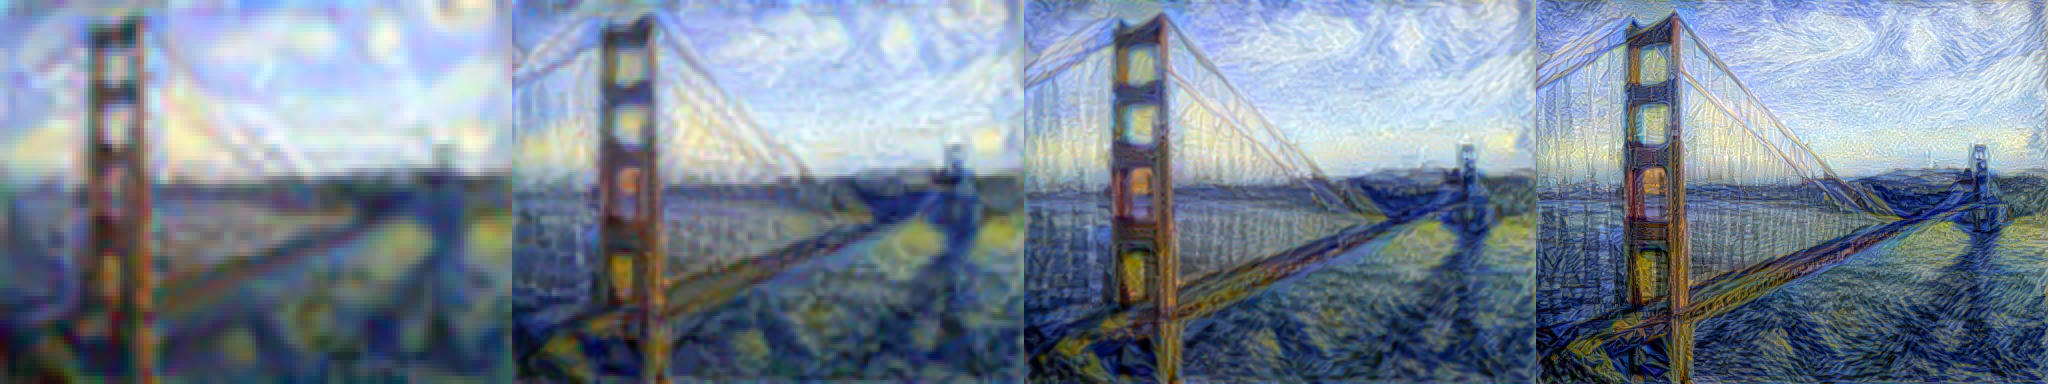

In [68]:
g = st.generate_multiscale(
    nlevels=4,
    content=p, 
    style=a, 
    seed=p,
    niter=50,
    yield_every=1)

pyr = list(g)
pyr = [x.scale_to(p.shape, resample=style.image.NEAREST) for x in pyr]

np.hstack(pyr).view(style.image.Image)

## Seamless

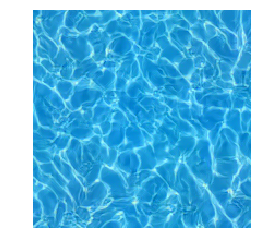

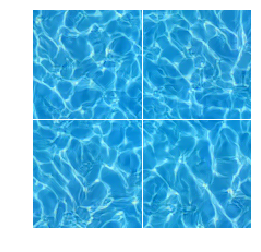

In [12]:
a = style.image.open('etc/water.jpg').scale_to(256)

border = 16
seamless = style.plugins.SeamlessPlugin(a.shape, border)

g = st.generate_multiscale(
    nlevels=3,
    content=a,
    style=a,
    lambda_content=0,
    niter=200,
    plugins=[seamless],
)

# Visualize result

x = style.image.borderless_view(next(g), border)
clear_output(wait=True)

def draw_stacked(x, draw_seam_border=False):
    hs = np.hstack((x,x,x))
    vs = np.vstack((hs,hs,hs))

    if draw_seam_border:
        h,w = x.shape[:2]       
        vs[:, [w,2*w]] = 1
        vs[[h,2*h]]=1

    return vs.view(style.image.Image)
        
g = draw_stacked(x, draw_seam_border=False)
plt.figure()
plt.imshow(g[x.shape[0]-100:x.shape[0]+100, x.shape[1]-100:x.shape[1]+100])
plt.axis('off')
plt.show()

gb = draw_stacked(x, draw_seam_border=True)
plt.figure()
plt.imshow(gb[x.shape[0]-100:x.shape[0]+100, x.shape[1]-100:x.shape[1]+100])
plt.axis('off')
plt.show()


## Creating larger textures

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.35s/it]


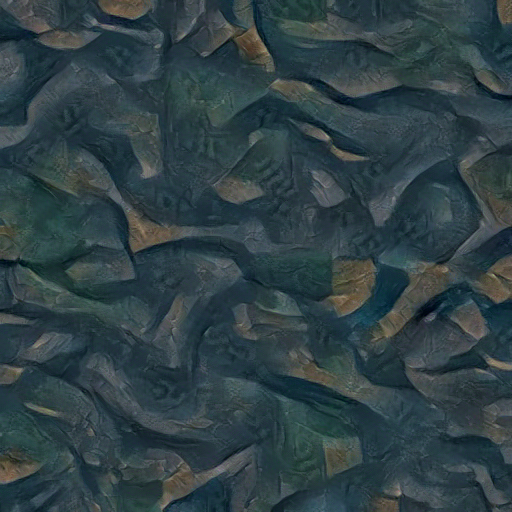

In [12]:
a = style.image.open('etc/picasso.jpg').rotate(90).scale_long_to(512)

t = style.TiledGeneration(st)

kwargs = dict(
    border=64,
    style=a,
    niter=100,
    lambda_content=0,
    lambda_tv=0
)


seed = style.image.new_random_white((128,128,3), mean=a)

x = next(t.generate(seed, grid_shape=(1,1), **kwargs))    # 128x128
x.save('128.png')
x = next(t.generate(x.up(), grid_shape=(1,1), **kwargs))  # 256x256
x.save('256.png')
x = next(t.generate(x.up(), grid_shape=(2,2), **kwargs))  # 512x512
x.save('512.png')

# Uncomment following lines to generate higher resolutions.
#x = next(t.generate(x.up(), grid_shape=(2,2), **kwargs))  # 1024x1024
#x = next(t.generate(x.up(), grid_shape=(4,4), **kwargs))  # 2048x2048
#x = next(t.generate(x.up(), grid_shape=(8,8), **kwargs))  # 4096x4096

x


## Synthesize 

In [8]:
a = style.image.open('wall.jpg').scale_long_to(256)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  2.74s/it]


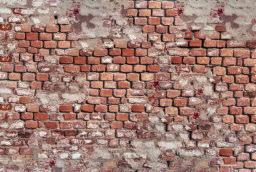

In [12]:
g = st.generate_multiscale(
    content=style.Content(lambda_loss=0),
    style=style.PatchStyle(a, [5,9], lambda_loss=1e-1),     
    seed=style.image.new_random_range(a.shape, 0.1, 0.95),
    niter=50)

next(g)

## Semantic Maps

In [5]:
#np.random.seed(456);
#torch.manual_seed(456);

seed_sem = style.image.open('etc/content_semantic2.png').scale_long_to(256, resample=style.image.NEAREST)
seed = style.image.new_random_range(seed_sem.shape, 0.1, 1)

a_sem = style.image.open('etc/monet_semantic.png').scale_long_to(256, resample=style.image.NEAREST)
a = style.image.open('etc/monet.jpg').scale_long_to(256)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 14.93s/it]


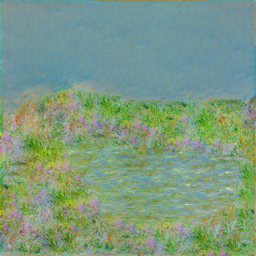

In [6]:
g = st.generate_multiscale(
    content=style.Content(lambda_loss=0),
    style=style.SemanticStyle(image=a, semantic_style_image=a_sem, semantic_content_image=seed_sem, layer_ids=[5,9]),
    seed=seed,
    niter=100)

x = next(g)
x

In [16]:
np.hstack((x, np.zeros((x.shape[0], 2, 3)), seed_sem)).view(style.image.Image).save('sem_content.png')
np.hstack((a, np.zeros((a.shape[0], 2, 3)), a_sem)).view(style.image.Image).save('sem_style.png')

In [7]:
x = torch.zeros(1,3,10,12)

In [8]:
x[:,0] = 1
x[:,1] = 2
x[:,2] = 3

In [9]:
import torch.nn.functional as F

In [11]:
f = F.unfold(x, 3)

In [14]:
f[0,:,0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        3., 3., 3., 3., 3., 3., 3., 3., 3.])